In [1]:
import os
import time
import torch
import sys
import random
from pprint import pprint
import torch.optim as optim
from torch.nn import DataParallel
import numpy as np
import shutil
from shutil import copyfile
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms as T
from matplotlib import pyplot as plt
from plot import post_epoch_plot, rgbd_gradients_dataset_first_n
# %matplotlib notebook
from models import SpecialFuseNet
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from train import FuseNetTrainer
from functions import torch2np_u8

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
CWD         = os.getcwd()
DATASET_DIR = os.path.join(CWD,'data','nyuv2_validation')
DATASET_SIZE = len([name for name in os.listdir(os.path.join(DATASET_DIR,'rgb')) if 
                            os.path.isfile(os.path.join(DATASET_DIR,'rgb',name))])
CKPT_DIR    = os.path.join(CWD,'checkpoints')
print(f'[I] - CWD={CWD}')
print(f'[I] - DATASET_DIR={DATASET_DIR}')
print(f'[I] - DATASET_SIZE={DATASET_SIZE}')
print(f'[I] - CKPT_DIR={CKPT_DIR}')
sys.path.append(CKPT_DIR)
pprint(sys.path)
constant_index = random.randint(0, DATASET_SIZE-1)
print(f'[I] - Using Index={constant_index}')

[I] - CWD=/home/manor/cs236781-DeepLearning/project/master
[I] - DATASET_DIR=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_validation
[I] - DATASET_SIZE=10
[I] - CKPT_DIR=/home/manor/cs236781-DeepLearning/project/master/checkpoints
['/home/manor/cs236781-DeepLearning/project/master',
 '/home/manor/anaconda3/envs/cs236781-project/lib/python37.zip',
 '/home/manor/anaconda3/envs/cs236781-project/lib/python3.7',
 '/home/manor/anaconda3/envs/cs236781-project/lib/python3.7/lib-dynload',
 '',
 '/home/manor/.local/lib/python3.7/site-packages',
 '/home/manor/anaconda3/envs/cs236781-project/lib/python3.7/site-packages',
 '/home/manor/anaconda3/envs/cs236781-project/lib/python3.7/site-packages/IPython/extensions',
 '/home/manor/.ipython',
 '/home/manor/cs236781-DeepLearning/project/master/checkpoints']
[I] - Using Index=8


In [4]:
filenames = os.listdir(CKPT_DIR)

models_files = dict()

for filename in os.listdir(CKPT_DIR):
    if filename.endswith('.pt'):
        f = filename[:-3]
    elif filename.endswith('_res.pkl'):
        f = filename[:-8]
    elif filename.endswith('_hp.py'):
        f = filename[:-6]
    if f in models_files:
        models_files[f].append(filename)
    else:
        models_files[f] = [filename]

[I] - MODEL_PATH=/home/manor/cs236781-DeepLearning/project/master/checkpoints/special_fusenet,img_size=64,64,batch_size=32,betas=0.9,0.99,lr=0.01,momentum=0.9.pt
[I] - Load Model ... Done.
[I] - Init SpecialFuseNet
    - warm start=True
    - BN momentum=0.1
    - dropout_p=0.4    - overfit_mode=False
[I (rgbd_gradients_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_validation
                             - image_size=(64, 64)
                             - use_transforms=True
                             - overfit_mode=False
                             - constant_index=None

[I] - |self|=10


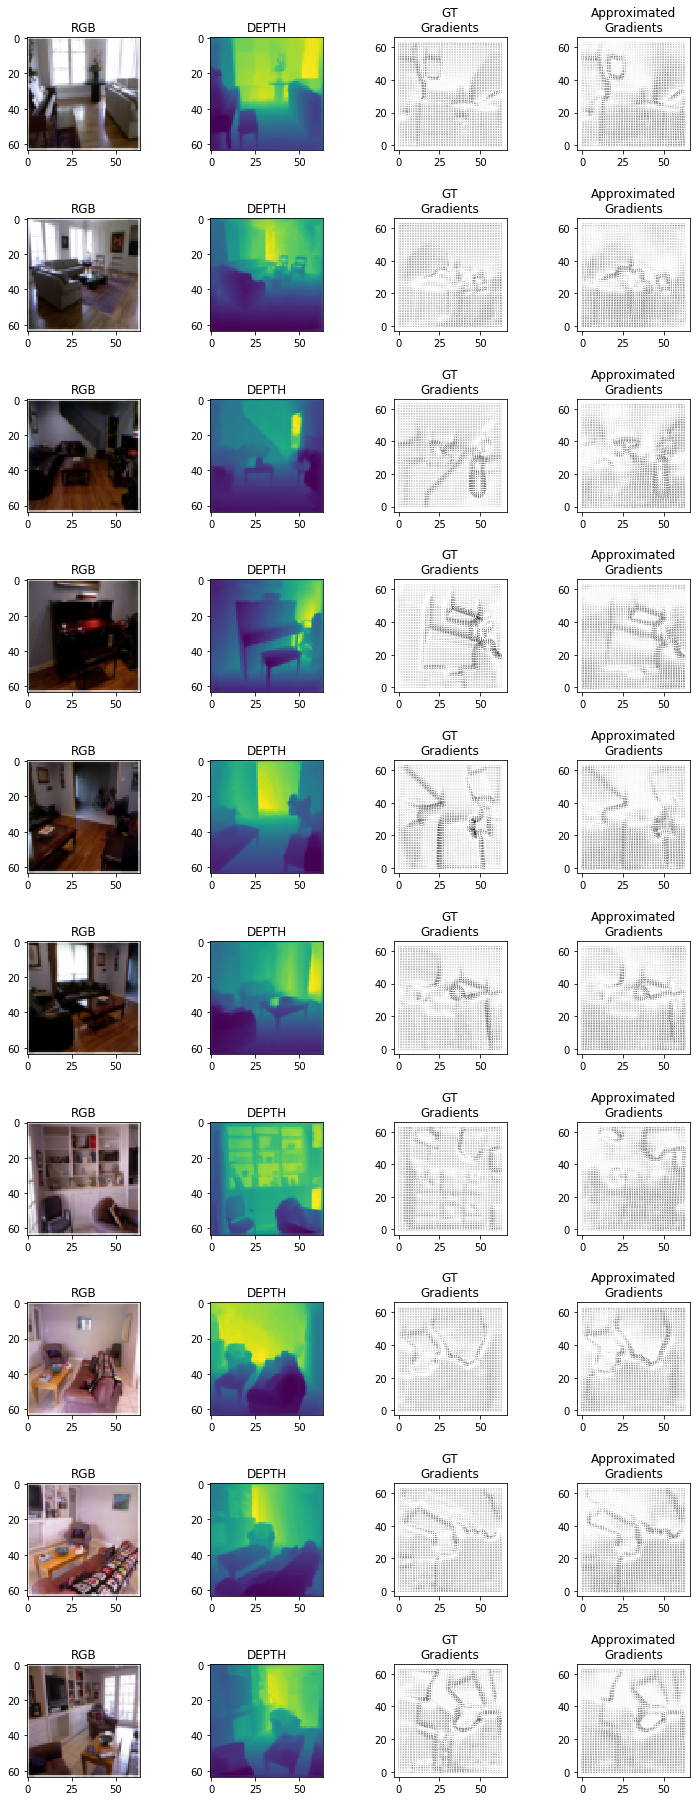

[I] - MODEL_PATH=/home/manor/cs236781-DeepLearning/project/master/checkpoints/special_fusenet,img_size=64,64,batch_size=32,betas=0.9,0.99,lr=0.01,momentum=0.99.pt
[I] - Load Model ... Done.
[I] - Init SpecialFuseNet
    - warm start=True
    - BN momentum=0.1
    - dropout_p=0.4    - overfit_mode=False
[I (rgbd_gradients_dataset)] - root=/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_validation
                             - image_size=(64, 64)
                             - use_transforms=True
                             - overfit_mode=False
                             - constant_index=None

[I] - |self|=10


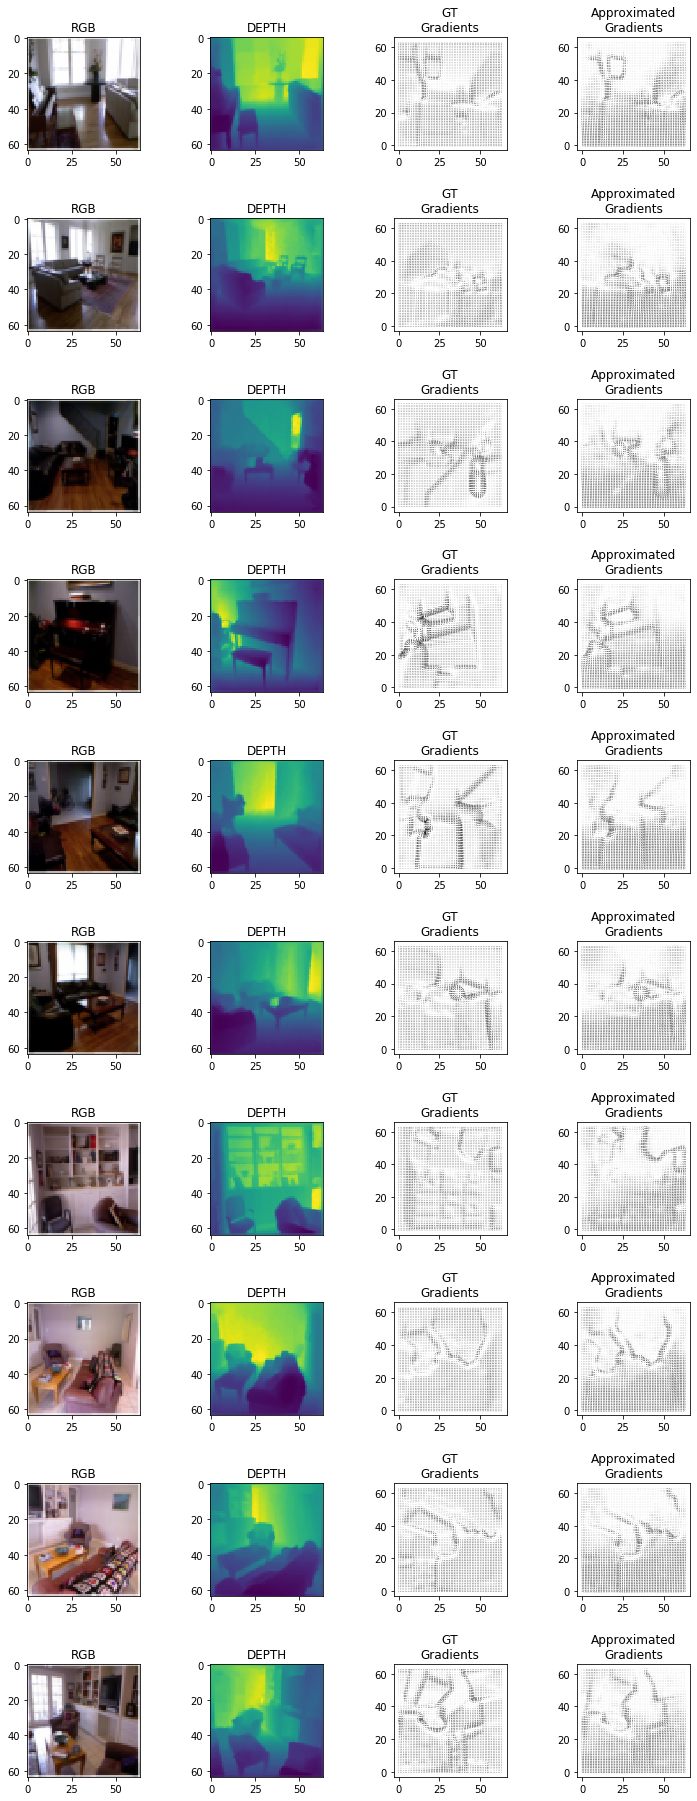

In [15]:
for exp_name, exp_data in models_files.items(): 
    for f in exp_data:
        if f.endswith('_hp.py'):
            copyfile(os.path.join(CKPT_DIR, f),os.path.join(CWD, "curr_hp.py"))
            from curr_hp import *
            os.remove(os.path.join(CWD, "curr_hp.py"))
        elif f.endswith('.pt'):
            MODEL_NAME  = f
            MODEL_PATH  = os.path.join(CKPT_DIR,MODEL_NAME)
            if os.path.exists(MODEL_PATH):
                print(f'[I] - MODEL_PATH={MODEL_PATH}')
                try:
                    print(f'[I] - Load Model ...', end=' ')
                    saved_state = torch.load(MODEL_PATH, map_location=device)
                    print('Done.')
                except Exception as e:
                    print(e)
            else:
                print(f"[E] - MODEL_PATH={MODEL_PATH} Doesn't exist!")

    fusenet = SpecialFuseNet()
    fusenet.to(device)
    fusenet = DataParallel(fusenet).to(device)

    fusenet.load_state_dict(saved_state['model_state'])
    
#     rgbd_grads_ds = rgbd_gradients_dataset(root=DATASET_DIR, use_transforms=True,
#                                            image_size=IMAGE_SIZE, constant_index=constant_index)
    rgbd_grads_ds = rgbd_gradients_dataset(root=DATASET_DIR, use_transforms=True,
                                           image_size=IMAGE_SIZE)
    
    fig, axes = plt.subplots(nrows=len(rgbd_grads_ds), ncols=4, figsize=(32,32), subplot_kw={'aspect': 1},
                             gridspec_kw=dict(wspace=0.3, hspace=0.6, left=0, right=0.3))
#     plt.tight_layout()
    
    for i,sample in enumerate(rgbd_grads_ds):
        rgb        = sample['rgb']
        depth      = sample['depth']
        x_gt       = sample['x']
        y_gt       = sample['y']
        rgb_size   = tuple(rgb.shape)
        depth_size = tuple(depth.shape)
        grads_size = tuple(x_gt.shape)
        x_gt       = x_gt.squeeze(0)
        y_gt       = y_gt.squeeze(0)
        rgb_im     = torch2np_u8(rgb)
        depth_im   = torch2np_u8(depth)

        axes[i,0].imshow(rgb_im)
        axes[i,0].set_title('RGB')
        axes[i,1].imshow(depth_im)
        axes[i,1].set_title('DEPTH')
        
        X_gt,Y_gt = np.meshgrid(np.arange(x_gt.shape[1]), np.arange(x_gt.shape[0]))
        axes[i,2].quiver(X_gt, Y_gt, x_gt, y_gt, pivot='tip', units='xy')
        axes[i,2].set_title('GT\nGradients')

        with torch.no_grad():
            xy   = fusenet(rgb_inputs=rgb.unsqueeze(0), depth_inputs=depth.unsqueeze(0))

        x = xy[:,0,:,:]
        y = xy[:,1,:,:]
        if len(x.shape) == 3:
            x = x[:,None,:,:]
        if len(y.shape) == 3:
            y = y[:,None,:,:]

        x = x[0,:,:,:].squeeze(0)
        y = y[0,:,:,:].squeeze(0)

        X,Y = np.meshgrid(np.arange(x.shape[1]), np.arange(x.shape[0]))
        axes[i,3].quiver(X, Y, x, y, pivot='tip', units='xy')
        axes[i,3].set_title('Approximated\nGradients')

    plt.show()